In [1]:
import numpy as np
import glob, time, shutil, os, joblib, tqdm, pickle, json, pprint
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers

In [3]:
from config import BACKBONE, USE_MY_DATASET, USE_RLVS_DATASET, INPUT_DIM, IF_MXNET_MODEL,\
    PATH, HISTORY_PATH, LOG_PATH, MODEL_PATH, RESULT_PATH, DEBUG, CROSS_DATASET, PARTITION

In [4]:
model_configuration ={'Backbone':BACKBONE,
                      'Use_My_Dataset':USE_MY_DATASET,
                      'Use_Rlvs_Dataset':USE_RLVS_DATASET,
                      'Input_Dim':INPUT_DIM,
                      'If_Mxnet_Model':IF_MXNET_MODEL,
                      'Path':PATH,
                      'History_Path':HISTORY_PATH,
                      'Log_Path':LOG_PATH,
                      'Model_Path':MODEL_PATH,
                      'Result_Path':RESULT_PATH,
                      'Debug':DEBUG,
                      'Cross_Dataset':CROSS_DATASET,
                      'Partition':PARTITION}

pprint.pprint(model_configuration)

{'Backbone': 'P3D',
 'Cross_Dataset': '',
 'Debug': True,
 'History_Path': './models_history/P3D_My_Dataset_Rlvs_Dataset',
 'If_Mxnet_Model': True,
 'Input_Dim': (2, 2048),
 'Log_Path': './tensorboard_log/P3D_My_Dataset_Rlvs_Dataset',
 'Model_Path': './saved_models/P3D_My_Dataset_Rlvs_Dataset',
 'Partition': 0.9,
 'Path': 'P3D_My_Dataset_Rlvs_Dataset',
 'Result_Path': './generated_result/P3D_My_Dataset_Rlvs_Dataset',
 'Use_My_Dataset': True,
 'Use_Rlvs_Dataset': True}


In [5]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
[make_dir(i) for i in [HISTORY_PATH, LOG_PATH, MODEL_PATH, RESULT_PATH]]

[None, None, None, None]

In [6]:
#BACKBONE = "denseNet201"
#from tensorflow.keras.applications.densenet import preprocess_input
#backbone = tf.keras.applications.DenseNet201(include_top=False,weights="imagenet",pooling='avg')

In [7]:
def times():
    now = datetime.now()
    return str(now.strftime("%d-%m-%Y..%H.%M.%S"))

def save(name,data,about="Undocumented"):
    
    '''This function saves file as sav with Time extension'''
    about += " at "+times()
    filename = name +"_"+ times()+'.sav' 
    joblib.dump([about,data], filename)
    print('Successfully Pickled->',name)
    
def Load(name):
    about,data = joblib.load(name)
    print("About "+name+": \n"+about)
    return data

def ShuffleIndex(l,seed=42):
    permutation  = np.random.RandomState(seed=seed).permutation((l))
    inversePermutation = np.argsort(permutation)
    return permutation, inversePermutation

def dict_as_json(data, path):
    with open(path, 'w') as f:
        json.dump(data, f)
        
def json_to_dict(path):
    with open(path, 'r') as f:
        return json.load(f)[0]
    

In [8]:
def get_model(dimension = 512,summary = False,input_shape = INPUT_DIM):
    
    FeatureInput = Input(shape=input_shape)
    Average_feature = layers.Flatten()(FeatureInput) if  IF_MXNET_MODEL else tf.reduce_max(FeatureInput,-2)*.25 + tf.reduce_mean(FeatureInput,-2)*.75
    
    AudioInput =   Input(shape=(1024))
    audio_ = layers.Dense(dimension//4,kernel_initializer='normal', activation='linear')(AudioInput)
    audio_ = layers.BatchNormalization()(audio_)
    audio_ = layers.Activation(tf.nn.relu)(audio_)
    audio_ = layers.Dropout(.5)(audio_)
    
    video_ = layers.Flatten()(Average_feature)
    video_ = layers.Dense(dimension//2,kernel_initializer='normal', activation='linear')(video_)
    video_ = layers.BatchNormalization()(video_)
    video_ = layers.Activation(tf.nn.relu)(video_)
    video_ = layers.Dropout(.5)(video_)
    
    combined = layers.concatenate([video_,audio_],axis=1)
    
    output = layers.Dense(1,kernel_initializer='normal', activation='sigmoid',name = 'classifier')(combined)
    
    model = Model(inputs= [FeatureInput,AudioInput], outputs = output)
    model.compile(optimizer=tf.optimizers.Nadam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])
    
    if summary:print(model.summary())
    
    return model

In [9]:

def get_callbacks():
    """define models callbacks"""#checkpoint = tf.keras.callbacks.ModelCheckpoint('violenceNet.h5',save_best_only=True)
    my_callbacks = [#tf.keras.callbacks.EarlyStopping(patience=10,min_delta= .005,mode='auto',monitor="val_accuracy"),
                    tf.keras.callbacks.ModelCheckpoint(filepath = MODEL_PATH+'\model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.3f}.h5'),
                    tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH),]
    
    return my_callbacks

In [10]:
def get_my_data(DEBUG=False):
    positive_video = glob.glob(f'video_features\my_dataset\{BACKBONE}\\notPhysicalViolence\*')
    negative_video = glob.glob(f'video_features\my_dataset\{BACKBONE}\PhysicalViolence\*')
    
    positive_audio_embedding = glob.glob(r'audio_features\my_dataset\notPhysicalViolence\*')
    negative_audio_embedding = glob.glob(f'audio_features\my_dataset\PhysicalViolence\*')
    
    video_files = positive_video + negative_video
    audio_files = positive_audio_embedding + negative_audio_embedding
    
    print(f'{len(video_files)} videos and {len(audio_files)} audio files found in my dataset')
    
    videos = [np.load(video_files[k],allow_pickle=True) for k in range(len(video_files))]
    audios = [np.load(audio_files[k],allow_pickle=True).flatten() for k in range(len(audio_files))]
    labels = [0]*len(positive_video) + [1]*len(negative_video)
    
    videos = np.array(videos,dtype=np.float32)
    audios = np.array(audios,dtype=np.float32)
    labels = np.array(labels,dtype=np.int32)
    
    if DEBUG:
        idx = np.random.choice(range(len(videos)),size=10,replace=False)
        print('\n',list(zip(np.array(video_files)[idx],np.array(audio_files)[idx],labels[idx])))

    print('my data shape: ',videos.shape,audios.shape,labels.shape)
    
    return videos, audios, labels

In [11]:
rlvs_audios_embedding_not_found = []

def get_audio_embedding(audio_file):
    if os.path.exists(audio_file):
        return np.load(audio_file,allow_pickle=True).flatten()
    
    rlvs_audios_embedding_not_found.append(audio_file)
    return np.zeros(1024).flatten()

def naming(video_file):
    name  = video_file.split('\\')[-1][:-4]
    if name.split('.')[-1] in ['i3d10s','p3d5s','r21d']:
        name = name.replace('.'+name.split('.')[-1],'')
    return f'audio_features\\rlvs\{name}.npy'

def get_rlvs_data(DEBUG=False): 
    video_files = glob.glob(f'video_features\\rlvs\{BACKBONE}\*')
    
    print(f'{len(video_files)} videos found in rlvs dataset')

    videos = [np.load(video_files[k],allow_pickle=True) for k in range(len(video_files))]
    audios = [get_audio_embedding(naming(k)) for k in video_files]
    
    class_map = {'NV':0,'V':1}
    labels = [class_map[i.split('\\')[-1].split('_')[0]] for i in video_files]
    
    videos = np.array(videos,dtype=np.float32)
    audios = np.array(audios,dtype=np.float32)
    labels = np.array(labels,dtype=np.int32)
    
    if DEBUG:
        idx = np.random.choice(range(len(videos)),size=10,replace=False)
        print('\n',list(zip(np.array(video_files)[idx],
                       [(naming(k)) for k in np.array(video_files)[idx]],
                       labels[idx])))
    
    print("rlvs data shape: ",videos.shape,audios.shape,labels.shape)
    print(f'{len(rlvs_audios_embedding_not_found)} audio files not found')
    
    return videos, audios, labels

In [12]:
def get_all_data(my_data = False, rlvs = False,DEBUG=False):
    videos, audios, labels = None, None, None
    
    if my_data:
        my_videos, my_audios, my_labels = get_my_data(DEBUG)
        videos = np.concatenate((videos,my_videos), axis = 0) if videos is not None else my_videos
        audios = np.concatenate((audios,my_audios), axis = 0) if audios is not None else my_audios
        labels = np.concatenate((labels,my_labels), axis = 0) if labels is not None else my_labels

    if rlvs:
        rlvs_videos, rlvs_audios, rlvs_labels = get_rlvs_data(DEBUG)
        videos = np.concatenate((videos,rlvs_videos), axis = 0) if videos is not None else rlvs_videos
        audios = np.concatenate((audios,rlvs_audios), axis = 0) if audios is not None else rlvs_audios
        labels = np.concatenate((labels,rlvs_labels), axis = 0) if labels is not None else rlvs_labels
     
    return videos, audios, labels

def get_shuffled_data(videos, audios, labels,from_storage= None):
    
    if from_storage: 
        permutation, inversePermutation = np.load('history\permutation_index.npy',allow_pickle=True)
    else:  permutation, inversePermutation = ShuffleIndex(len(videos))
    
    videos = videos[permutation]
    audios = audios[permutation]
    labels = labels[permutation]
    
    #np.save('config\permutation_index.npy',[permutation, inversePermutation],allow_pickle=True)
    return videos, audios, labels, permutation, inversePermutation   

def split_train_test_data(videos, audios, labels,partition = PARTITION):
    """split data into train, test, validation"""
    
    if partition<=1:  partition = int(len(videos)*partition)
    
    train_videos = videos[:partition]
    train_audios = audios[:partition]
    train_labels = labels[:partition]
    
    test_videos = videos[partition:]
    test_audios = audios[partition:]
    test_labels = labels[partition:]

    
    
    return train_videos, train_audios, train_labels, test_videos, test_audios, test_labels
    
def get_data_generator(videos, audios, labels, batch_size):
    while True:
        permutation, inversePermutation = ShuffleIndex(len(videos))
        videos = videos[permutation]
        audios = audios[permutation]
        labels = labels[permutation]
        
        for i in range(0,len(videos),batch_size):
            yield videos[i:i+batch_size], audios[i:i+batch_size], labels[i:i+batch_size]

In [13]:
model = get_model(dimension = 256, summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 2048)]    0           []                               
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 4096)         0           ['flatten[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                              

In [14]:
videos, audios, labels = get_all_data(my_data = USE_MY_DATASET, rlvs = USE_RLVS_DATASET, DEBUG=DEBUG)

1216 videos and 1216 audio files found in my dataset

 [('video_features\\my_dataset\\P3D\\notPhysicalViolence\\1667.Vanilla.p3d5s.npy', 'audio_features\\my_dataset\\notPhysicalViolence\\1667.Vanilla.npy', 0), ('video_features\\my_dataset\\P3D\\notPhysicalViolence\\1465.Vanilla.p3d5s.npy', 'audio_features\\my_dataset\\notPhysicalViolence\\1465.Vanilla.npy', 0), ('video_features\\my_dataset\\P3D\\PhysicalViolence\\3139.Violence.p3d5s.npy', 'audio_features\\my_dataset\\PhysicalViolence\\3139.Violence.npy', 1), ('video_features\\my_dataset\\P3D\\notPhysicalViolence\\1633.Vanilla.p3d5s.npy', 'audio_features\\my_dataset\\notPhysicalViolence\\1633.Vanilla.npy', 0), ('video_features\\my_dataset\\P3D\\notPhysicalViolence\\3205.Vanilla.p3d5s.npy', 'audio_features\\my_dataset\\notPhysicalViolence\\3205.Vanilla.npy', 0), ('video_features\\my_dataset\\P3D\\notPhysicalViolence\\1681.Vanilla.p3d5s.npy', 'audio_features\\my_dataset\\notPhysicalViolence\\1681.Vanilla.npy', 0), ('video_features\\my_dat

In [15]:
videos, audios, labels, perm, Iperm = get_shuffled_data(videos, audios, labels)

In [16]:
train_videos, train_audios, train_labels, test_videos, test_audios, test_labels = split_train_test_data(videos, audios, labels)
if len(CROSS_DATASET):
    print('\n','Cross dataset evaluation: ',CROSS_DATASET)
    test_videos, test_audios, test_labels = get_rlvs_data() if CROSS_DATASET =='rlvs' else get_my_data()
    
print(f'\n\n{len(train_videos)} train videos, {len(test_videos)} test videos')



2894 train videos, 322 test videos


In [17]:
history = model.fit([train_videos,train_audios],train_labels, epochs=50,
                    verbose=1,steps_per_epoch=32,validation_split=.1,shuffle = True,
                    callbacks = get_callbacks())

Epoch 1/50
32/32 [==============================] - 3s 36ms/step - loss: 0.3632 - accuracy: 0.8437 - val_loss: 0.4281 - val_accuracy: 0.9034
Epoch 2/50
32/32 [==============================] - 1s 40ms/step - loss: 0.2106 - accuracy: 0.9313 - val_loss: 0.3337 - val_accuracy: 0.9172
Epoch 3/50
32/32 [==============================] - 1s 40ms/step - loss: 0.1464 - accuracy: 0.9558 - val_loss: 0.2561 - val_accuracy: 0.9448
Epoch 4/50
32/32 [==============================] - 1s 31ms/step - loss: 0.1208 - accuracy: 0.9658 - val_loss: 0.2391 - val_accuracy: 0.9000
Epoch 5/50
32/32 [==============================] - 1s 34ms/step - loss: 0.1015 - accuracy: 0.9693 - val_loss: 0.2449 - val_accuracy: 0.8862
Epoch 6/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0764 - accuracy: 0.9796 - val_loss: 0.1554 - val_accuracy: 0.9448
Epoch 7/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0666 - accuracy: 0.9854 - val_loss: 0.1413 - val_accuracy: 0.9655
Epoch 8/50
32

In [18]:
np.save(f'{HISTORY_PATH}\history.npy',history.history)
dict_as_json(history.history,HISTORY_PATH+'\history.json')

In [19]:
#model.load_weights('model\\violence_my_dataset.h5')

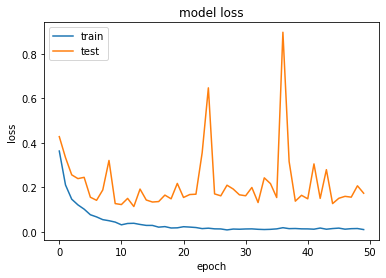

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
def get_best_model(history):
    """get the best model from history"""
    best_epoch = np.argmin(history['val_loss'])
    return history['model'][best_epoch]
def get_best_model_from_storage(path = MODEL_PATH):
    models_ = glob.glob(path+'\*.h5')
    best_model = np.argmax([int(i.split('\\')[-1].split('.')[-2]) for i in models_])
    print(f'best model is {models_[best_model]}')
    return models_[best_model]

In [22]:
model.load_weights(get_best_model_from_storage())

best model is ./saved_models/P3D_My_Dataset_Rlvs_Dataset\model.07-0.14-0.966.h5


In [23]:
prediction = model.predict([test_videos,test_audios],verbose=1,steps=len(test_videos)//64)
prediction = np.round(prediction,2)
classification = np.rint(prediction).astype(int).flatten()

5/5 [==============================] - 0s 3ms/step


In [24]:
def generate_report(a,b,v=0): #actual,predicted
    a = np.array(a).astype(int)
    b = np.array(b).astype(int)
    if v: 
        a = 1-a
        b = 1-b

    tp = sum((a==0) & (b==0))
    tn = sum((a==1) & (b==1))
    fn = sum((a==0) & (b==1))
    fp = sum((a==1) & (b==0))
    #print("TP: ",tp," TN: ",tn,' FN: ',fn,' FP: ',fp)
    
    confusion_matrix = {'TP': int(tp), 'TN': int(tn), 'FN': int(fn), 'FP': int(fp)}
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn) 
    f1_score = (2*precision*recall)/ (precision+recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    support = sum(a==v)
    accuracy ,precision,recall,f1_score,support = np.round([accuracy ,precision,recall,f1_score,support],3)
    
    report = {'class':v,
              'No of test samples':len(a),
              'support': int(support),
              'confusion_matrix':confusion_matrix,
              'accuracy':accuracy,
              'precision':precision,
              'recall':recall,
              'f1_score':f1_score
              }
    
    return report

In [25]:
result = {'Time':times(),
          'model_name':PATH,
          'My dataset':USE_MY_DATASET,
          'RLVS dataset':USE_RLVS_DATASET,
          'BACKBONE':BACKBONE,
          'INPUT_DIM':INPUT_DIM,
          'No Physical Violence':generate_report(test_labels,classification,0),
          'Physical Violence':   generate_report(test_labels,classification,1),
          'Best model':get_best_model_from_storage()
          }

pprint.pprint(result)

best model is ./saved_models/P3D_My_Dataset_Rlvs_Dataset\model.07-0.14-0.966.h5
{'BACKBONE': 'P3D',
 'Best model': './saved_models/P3D_My_Dataset_Rlvs_Dataset\\model.07-0.14-0.966.h5',
 'INPUT_DIM': (2, 2048),
 'My dataset': True,
 'No Physical Violence': {'No of test samples': 322,
                          'accuracy': 0.938,
                          'class': 0,
                          'confusion_matrix': {'FN': 14,
                                               'FP': 6,
                                               'TN': 156,
                                               'TP': 146},
                          'f1_score': 0.936,
                          'precision': 0.961,
                          'recall': 0.912,
                          'support': 160},
 'Physical Violence': {'No of test samples': 322,
                       'accuracy': 0.938,
                       'class': 1,
                       'confusion_matrix': {'FN': 6,
                                            'F

In [26]:
dict_as_json(result,RESULT_PATH+'\\result.json')

In [27]:
#(0.698, 1396)
#(0.8187633262260128, 768)

In [6]:
1 ^ 1,1^0,0^0

(0, 1, 0)

In [9]:
LEARNING_RATE = .0004
def scheduler(epoch, lr):
    #scheduler = lambda epoch,lr: lr *.5 if epoch>5 else lr
    if epoch < 5: return lr
    else:          return LEARNING_RATE - LEARNING_RATE*.33*(epoch//5)

[scheduler(i,LEARNING_RATE) for i in range(50)]# else LEARNING_RATE]

[0.0004,
 0.0004,
 0.0004,
 0.0004,
 0.0004,
 0.000268,
 0.000268,
 0.000268,
 0.000268,
 0.000268,
 0.000136,
 0.000136,
 0.000136,
 0.000136,
 0.000136,
 3.999999999999989e-06,
 3.999999999999989e-06,
 3.999999999999989e-06,
 3.999999999999989e-06,
 3.999999999999989e-06,
 -0.00012800000000000002,
 -0.00012800000000000002,
 -0.00012800000000000002,
 -0.00012800000000000002,
 -0.00012800000000000002,
 -0.00026,
 -0.00026,
 -0.00026,
 -0.00026,
 -0.00026,
 -0.00039200000000000004,
 -0.00039200000000000004,
 -0.00039200000000000004,
 -0.00039200000000000004,
 -0.00039200000000000004,
 -0.0005240000000000002,
 -0.0005240000000000002,
 -0.0005240000000000002,
 -0.0005240000000000002,
 -0.0005240000000000002,
 -0.0006560000000000001,
 -0.0006560000000000001,
 -0.0006560000000000001,
 -0.0006560000000000001,
 -0.0006560000000000001,
 -0.0007880000000000001,
 -0.0007880000000000001,
 -0.0007880000000000001,
 -0.0007880000000000001,
 -0.0007880000000000001]

In [10]:
LR_MAX = 0.0001
LR_MIN = 0.00001
LR_EXP_DECAY = 0.85

def lrfn(epoch):
    lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch//5) + LR_MIN
    return lr
for i  in range(50):
    print(lrfn(i))

0.0001
0.0001
0.0001
0.0001
0.0001
8.65e-05
8.65e-05
8.65e-05
8.65e-05
8.65e-05
7.5025e-05
7.5025e-05
7.5025e-05
7.5025e-05
7.5025e-05
6.527125e-05
6.527125e-05
6.527125e-05
6.527125e-05
6.527125e-05
5.6980562499999995e-05
5.6980562499999995e-05
5.6980562499999995e-05
5.6980562499999995e-05
5.6980562499999995e-05
4.9933478125e-05
4.9933478125e-05
4.9933478125e-05
4.9933478125e-05
4.9933478125e-05
4.3943456406249995e-05
4.3943456406249995e-05
4.3943456406249995e-05
4.3943456406249995e-05
4.3943456406249995e-05
3.8851937945312494e-05
3.8851937945312494e-05
3.8851937945312494e-05
3.8851937945312494e-05
3.8851937945312494e-05
3.4524147253515625e-05
3.4524147253515625e-05
3.4524147253515625e-05
3.4524147253515625e-05
3.4524147253515625e-05
3.084552516548828e-05
3.084552516548828e-05
3.084552516548828e-05
3.084552516548828e-05
3.084552516548828e-05


In [5]:
text= "Effects of Watching Violence Movies On The Attudes Concerning Aggression Among Middle Schoolboys (13-17 years old) at International Schools In Kuala Lumpur, Malaysia"
"_".join([i for i in text.split()])

'Effects_of_Watching_Violence_Movies_On_The_Attudes_Concerning_Aggression_Among_Middle_Schoolboys_(13-17_years_old)_at_International_Schools_In_Kuala_Lumpur,_Malaysia'